<a href="https://colab.research.google.com/github/GamaLab42/LivroBioprocessos/blob/main/Filtra%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from scipy.optimize import newton
from scipy.optimize import bisect
from scipy import optimize as opt


T   = 293.15        # K
k   = 1.380649E-23  # J/K
rp  = 100.0E-9      # meter
zn  = 12            # Number ofneighboring particles
z   = 1             # Ion valence
xi0 = 30E-3         # Volt
A   = 10**(-20)     # J
c0  = 10**(-5)      # mol/L
Na  = 6.022E23
epsilon   = 80.0              # Constante dielétrica do meio (-)
epsilon0  = 8.854E-12         # Constante dielétrica do vácuuo (C^2 m-1 J-1)
e         = 1.602176E-19      # Carga elementar do eletron (C)

v     = 8.333E-5              # Velocidade média (m/s)
u0    = 1.0E-3                # Viscosity (kg (m s)-1)
Lp    = 1.0E-9                # Permeability m/(Pa s)
R     = 3E-3                  # Raio da fibra (m)
rho   = 1E+3                  # Densidade do fluido (kg m-3)
L     = 0.028 #1.2                   # Comprimento da membrana (m)
phi_b = 1E-3                  # Fração volumétrica do bulk


Q0    = v*np.pi*R**2          # Vazão de entrada
Rm    = 1/Lp/u0               # Resistência da torta (1/m)

kappa = np.sqrt(np.power(e,2)*Na*float(2)*c0*float(1000)/epsilon/epsilon0/k/T)

phi_cp = np.pi*np.sqrt(2)/6

In [ ]:
# Contribuição entrópica
def Osm_ent(phi):
  X = 6.028*np.exp((phi_cp-phi)*(7.9-3.9*(phi_cp-phi)))
  aux = 1-3*phi + 3*phi**2 - 1.04305*phi**3
  return 3*k*T*phi/(4*np.pi*rp**3)*(1+phi+phi**2-0.67825*phi**3-phi**4-0.5*phi**5-X*phi**6)/aux

In [ ]:
# Contribuição de van der Waals
def Osm_vdW(phi):
  aux = phi_cp-phi_cp**(1/3)*phi**(2/3)
  return -zn*A*phi**3/48/np.pi/rp**3/aux**2

In [ ]:
# Contribuição eletrostática
xi = e*z*xi0/k/T
def Osm_ele(phi):
  aux = kappa*rp*np.power(phi,-1/3)*np.cosh(-kappa*rp*(1-np.power(phi,-1/3))) - np.sinh(-kappa*rp*(1-np.power(phi,-1/3)))
  return ((8/3)*np.pi*np.sqrt(2))*((3/(4*np.pi*np.sqrt(2)))**(2/3))*Na*k*T*c0*(np.cosh(kappa*rp*xi/(aux))-1)*1000

In [ ]:
def Osm_T(phi):
  return Osm_ent(phi)+Osm_vdW(phi)+Osm_ele(phi)

In [ ]:
phi = np.linspace(1e-8,0.73,100)

In [ ]:
plt_Osm_ent = []
plt_Osm_vdW = []
plt_Osm_ele = []
plt_total = []
for i in range(np.size(phi)):
  plt_Osm_ent.append(Osm_ent(phi[i]))
  plt_Osm_vdW.append(Osm_vdW(phi[i]))
  plt_Osm_ele.append(Osm_ele(phi[i]))
  plt_total.append(Osm_T(phi[i]))

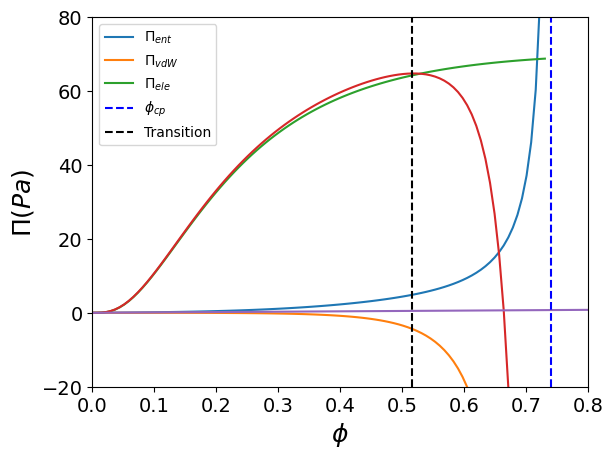

In [ ]:
peaks, _ = find_peaks(plt_total)

plt.plot(phi,plt_Osm_ent, label = '$\Pi_{ent}$')
plt.plot(phi,plt_Osm_vdW, label = '$\Pi_{vdW}$')
plt.plot(phi,plt_Osm_ele, label = '$\Pi_{ele}$')
plt.plot(phi,plt_total)
plt.plot([0,1],[0,1])
plt.axvline(x = phi_cp, color = 'b', label = '$\phi_{cp}$',ls='--')
plt.axvline(x = phi[peaks[0]], color = 'black', label = 'Transition',ls='--')
plt.legend()
plt.ylim(-20,80) # Para rp = 100 nm
#plt.ylim(-5000,15000) # Para rp = 5 nm
plt.xlim(0,0.8)
plt.yticks(fontsize=14)
plt.ylabel('$\Pi(Pa)$', fontsize=18)
plt.xticks(fontsize=14)
plt.xlabel('$\phi$', fontsize=18)
plt.show()


In [ ]:
peaks, _ = find_peaks(plt_total)
phi_w = phi[peaks[0]]

Número de Reynolds:

$Re = \frac{2 Q \rho}{\pi R \mu_{b}}$

In [ ]:
def Rey(Q):
  return 2*Q*rho/np.pi/R/u0

 Fator de atrito:
 Para regime laminar, utiliza-se a relação de Poiseuille ($Re < 2100$):
 \\
 $f = 16/Re$

 Para regime turbulento (correlação de Blasius):
 \\
 $f = 0.0791/Re^{1/4}$

In [ ]:
def friction(x):
  Reynolds = Rey(x)
  if (Reynolds<2100):
    return 16/Reynolds
  if (Reynolds>=2100):
    return 0.0791/np.power(Reynolds,1/4)

Variação da viscosidade com a fração volumétrica (fórmula de Eilers-Chong) (Kissa, 1999):

$\mu(\phi)$ = $\mu_{b}\left(1 + \frac{1.25\phi}{1-\phi/\phi_{cp}}  \right)^{2}$

In [ ]:

def u(phi):
  return u0*(1+1.25*phi/(1-phi/phi_cp))**2

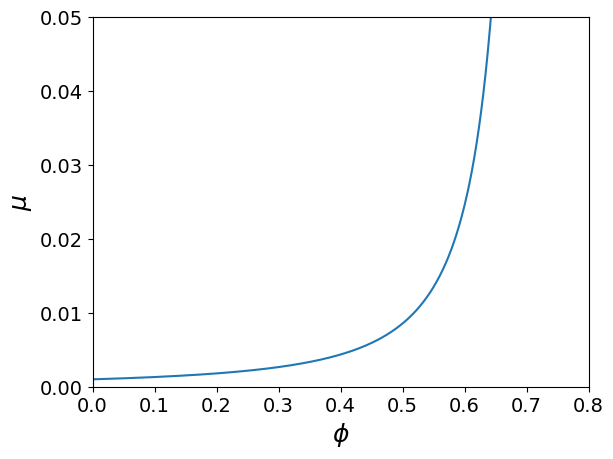

In [ ]:
phii = np.linspace(1E-4,phi_cp*0.99,1000)
plt.plot(phii, u(phii))

plt.xlim(0,0.8)
plt.ylim(0,0.05)
plt.yticks(fontsize=14)
plt.ylabel('$\mu$', fontsize=18)
plt.xticks(fontsize=14)
plt.xlabel('$\phi$', fontsize=18)
plt.show()

Equação de Happel (1958) para o cálculo do coeficiente de difusão:
\
\
$D(\phi) = \frac{V_p}{6\pi \mu r_p H(\phi)}\frac{d\Pi}{d\phi}$
\
\
sendo:
\
$H(\phi) = \frac{6 + 4\phi^{5/3}}{6-9\phi^{1/3}+9\phi^{5/3}-6\phi^2}$

In [ ]:
def der(f,x): # Função para calcular derivada. argumentos: função e sua coordenada
    delta=1e-9*x
    return (f(x+delta)-f(x-delta))/(2*delta)

In [ ]:
def D(phi):
  aux = 6-9*np.power(phi,1/3)+9*np.power(phi,5/3)-6*np.power(phi,2)
  H   = (6+4*np.power(phi,5/3))/aux
  Vp  = (4/3)*np.pi*rp**3
  return Vp/6/np.pi/u0/rp/H*der(Osm_T,phi)


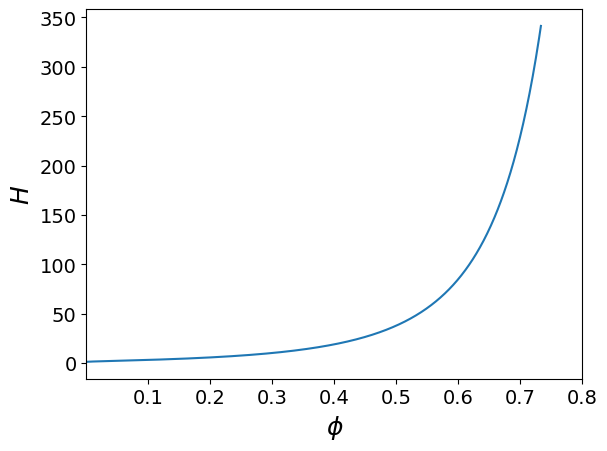

In [ ]:
def H(phi):
  aux = 6-9*np.power(phi,1/3)+9*np.power(phi,5/3)-6*np.power(phi,2)
  H   = (6+4*np.power(phi,5/3))/aux
  return H

plt.plot(phii, H(phii))
plt.xlim(1E-6,0.8)
plt.yticks(fontsize=14)
plt.ylabel('$H$', fontsize=18)
plt.xticks(fontsize=14)
plt.xlabel('$\phi$', fontsize=18)
plt.show()

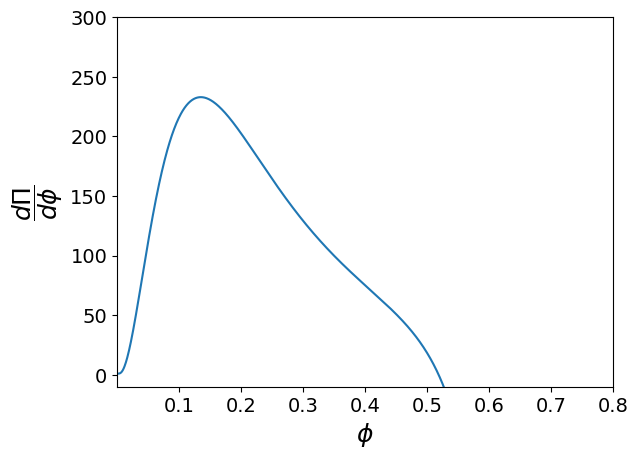

In [ ]:
plt.plot(phii, der(Osm_T,phii))

plt.xlim(1E-6,0.8)
plt.ylim(-10,300)
plt.yticks(fontsize=14)
plt.ylabel('$\dfrac{d\Pi}{d\phi}$', fontsize=18)
plt.xticks(fontsize=14)
plt.xlabel('$\phi$', fontsize=18)
plt.show()

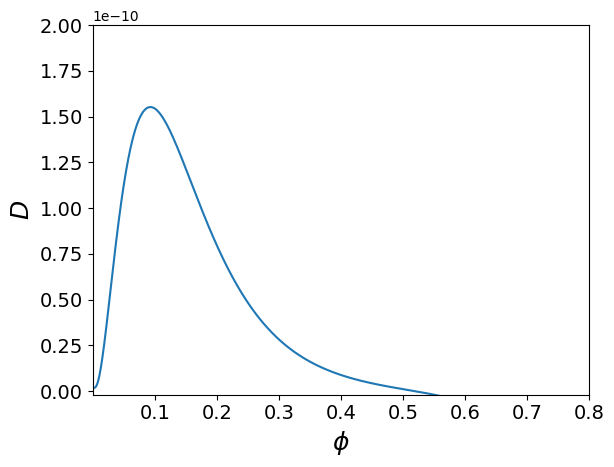

In [ ]:
plt.plot(phii, D(phii))

plt.xlim(1E-6,0.8)
plt.ylim(-0.2E-11,0.2E-9)
plt.yticks(fontsize=14)
plt.ylabel('$D$', fontsize=18)
plt.xticks(fontsize=14)
plt.xlabel('$\phi$', fontsize=18)
plt.show()

In [ ]:
########## Cálculo da integral dupla ###########
def INT(a,b):
    def f(x):
        return D(x)/(x*u(x)) # integral muda da função D(phi')/(phi'*mu(phi'))
    Integral = integrate.quad(f,a,b)  #integrate.quad(f,a,b)
    return Integral

def INT2(c,d):
    def g(x):
        y2=D(x)*INT(x,d)[0]  # Integral do produto D(phi)*integral de D(phi')/(phi'*mu(phi'))
        return y2
    Integral2 = integrate.quad(g,c,d)
    return Integral2

In [ ]:
def G(l_s): #função que calcula a integral passsando o limite superior
    G_phib_phiw = INT2(phi_b,l_s)[0] # O valor da função G(phib,phiw)
    return G_phib_phiw

In [ ]:
def Vw2(P, phi):
  return (P - Osm_T(phi))/u0/Rm

def Vw1(P, phi):
    Q = (Q0-2*np.pi*R*L*Vw2(P, phi))
    Vw = (Q/R)*np.sqrt(rho*friction(Q0)*G(phi)/(phi_b*np.pi*R*(Q0-Q)))
    return Vw

In [ ]:
phi = np.linspace(1E-2,phi_w,100)  # vetor com valores de phi
Pressão = np.zeros(len(phi)) # Inicializando o vetor de pressões calculadas
phi_plot = np.zeros(len(phi))

for i in range(len(phi)-1):

    def resolve(P):
        resto = (Vw1(P,phi[i]) - Vw2(P,phi[i]))
        return resto*1E0
    #ans = opt.root(resolve,10000) # chute inicial = 10 kPa para rp = 100 nm
    ans = opt.root(resolve,12400) # chute inicial = 12 kPa para rp = 5 nm
    Pressão[i] = ans['x']
    phi_plot[i] = phi[i]

<ipython-input-56-a62eaffda4ea>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Pressão[i] = ans['x']


In [ ]:
Vw_plot1 = []
Vw_plot2 = []

for i in range(len(Pressão)):
  phi_aux = phi[i]
  Vw_plot1.append(Vw1(Pressão[i],phi_plot[i]))


<ipython-input-38-1fa071c8d3ed>:4: RuntimeWarning: divide by zero encountered in power
  aux = kappa*rp*np.power(phi,-1/3)*np.cosh(-kappa*rp*(1-np.power(phi,-1/3))) - np.sinh(-kappa*rp*(1-np.power(phi,-1/3)))
<ipython-input-38-1fa071c8d3ed>:4: RuntimeWarning: invalid value encountered in scalar subtract
  aux = kappa*rp*np.power(phi,-1/3)*np.cosh(-kappa*rp*(1-np.power(phi,-1/3))) - np.sinh(-kappa*rp*(1-np.power(phi,-1/3)))
<ipython-input-38-1fa071c8d3ed>:4: RuntimeWarning: overflow encountered in cosh
  aux = kappa*rp*np.power(phi,-1/3)*np.cosh(-kappa*rp*(1-np.power(phi,-1/3))) - np.sinh(-kappa*rp*(1-np.power(phi,-1/3)))
<ipython-input-38-1fa071c8d3ed>:4: RuntimeWarning: overflow encountered in sinh
  aux = kappa*rp*np.power(phi,-1/3)*np.cosh(-kappa*rp*(1-np.power(phi,-1/3))) - np.sinh(-kappa*rp*(1-np.power(phi,-1/3)))
<ipython-input-53-a5defb051269>:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The 

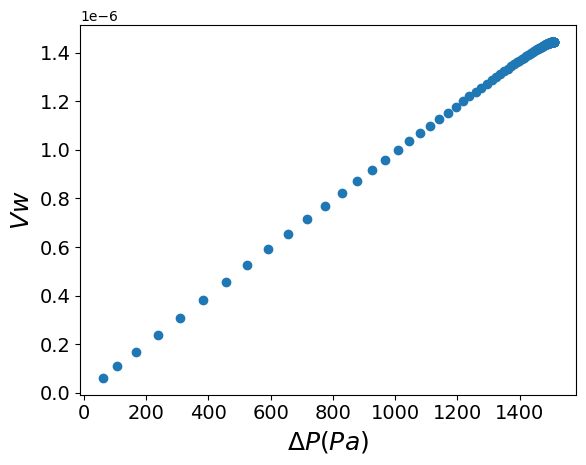

In [ ]:
plt.scatter(Pressão,Vw_plot1)

plt.yticks(fontsize=14)
plt.ylabel('$Vw$', fontsize=18)
plt.xticks(fontsize=14)
plt.xlabel('$\Delta P (Pa)$', fontsize=18)
plt.show()

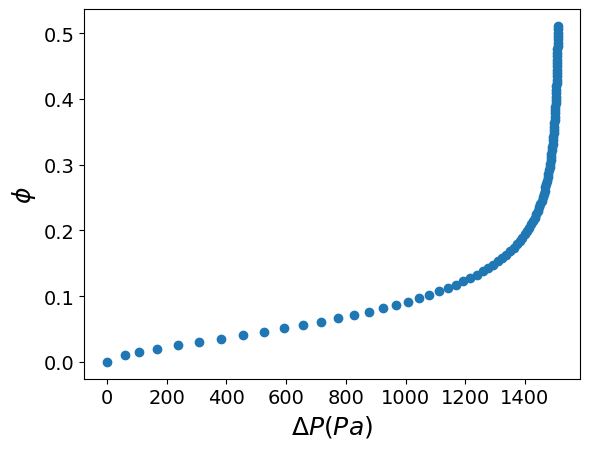

In [ ]:
plt.scatter(Pressão,phi_plot)

plt.yticks(fontsize=14)
plt.ylabel('$\phi$', fontsize=18)
plt.xticks(fontsize=14)
plt.xlabel('$\Delta P (Pa)$', fontsize=18)
plt.show()

In [ ]:
import math

Vw_plot1 = [0 if math.isnan(x) else x for x in Vw_plot1]
Vw_plot1 = [x * 1E+6 for x in Vw_plot1]
Pressão  = [x * 1E-3 for x in Pressão]


In [ ]:
import pandas as pd

df = pd.DataFrame({
    'Vw_plot1': Vw_plot1,
    'Pressao': Pressão
})

df = df[(df['Vw_plot1'] != 0) & (df['Pressao'] != 0)]

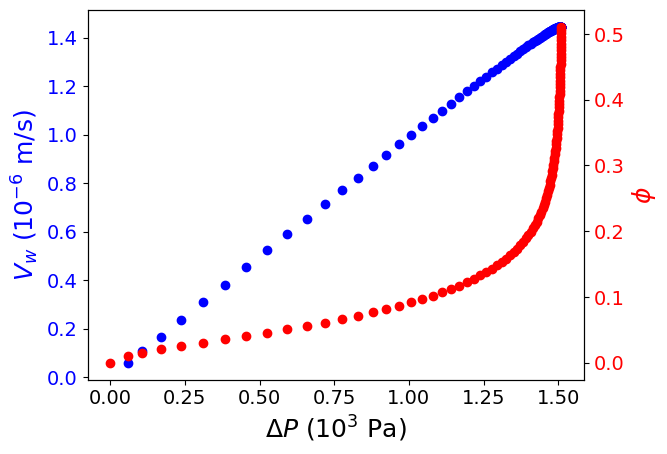

In [ ]:
fig, ax1 = plt.subplots()

ax1.scatter(df['Pressao'], df['Vw_plot1'], color='b')
ax1.set_xlabel('$\Delta P$ (10$^{3}$ Pa)', fontsize=18)
ax1.set_ylabel('$V_{w}$ (10$^{-6}$ m/s)', fontsize=18, color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

ax2 = ax1.twinx()

ax2.scatter(Pressão, phi_plot, color='r')
ax2.set_ylabel('$\phi$', fontsize=18, color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.tick_params(axis='y', labelsize=14)

plt.show()